# Will it Rain Tomorrow in New York?

## Rylan Larsen

## Task
Given historical weather data, can you predict whether tomorrow will be rainy in
New York? Any weather description that is a form of liquid precipitation is considered
rainy, such as those containing keywords “rain”, “thunderstorm”, “drizzle”, etc. You have
flexibility in defining “rainy" and “tomorrow” (e.g. next 24 hours from current hour).

## General Summary

- The metrics used to define performance on the test set were accuracy, precision, and recall. These were compared to the same metrics on the test set using my baseline prediction. I primarily used accuracy and loss during when evaluating training performance because accuracy is implemented in all machine learning approaches I tried (most notably in Keras as it runs). However, due to the class imbalance (fewer rainy days than not), accuracy was not sufficient for measuring the test data and precision and recall were added for the test data.

- Baseline metric: Whether it will rain tomorrow in New York (or not) can be fairly well predicted by whether it rained yesterday (~74% accuracy), my 'baseline' metric. Most of the models I tried did not outperform this 'persistence' prediction by a great deal in terms of accuracy, but did in terms of precision and recall. 

- The models outperform the baseline (using the previous day to predict the next) in terms of all metrics, but the biggest improvement over the baseline is in the precision and recall scores over the baseline. If time allowed, further parameter tweaking may slightly improve performance. More data (using other cities) would like be a better option.

- Models could be improved by potentially using other cities weather data to expand the training set, feature engineering, and/or more hyperparameter tuning.

Datasource: Kaggle, SelfishGene, https://www.kaggle.com/selfishgene/historical-hourly-weather-data

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score,precision_recall_fscore_support


from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM

from tensorflow.keras.optimizers import Adam, SGD

# Read data, explore distributions, handle missing values

The various attributes are scattered across multiple CSV files for a given city. I will read each of them, then combine them into a single dataframe for a given city (e.g. New York)

In [3]:
filenames = ['wind_speed.csv', 'wind_direction.csv', 'temperature.csv', 'pressure.csv','humidity.csv','weather_description.csv']
#list comprehension to read each of the above files in order into list
dfs = [pd.read_csv(file, index_col='datetime',parse_dates=['datetime'])['New York'] for file in filenames]

new_york=pd.concat(dfs, axis=1)
#redefine column names based on merged dataframes
new_york.columns=['wind_speed','wind_dir','temperature','pressure','humidity','desc']

Measurement data often can include missing values, which can cause problems for various algorithms. First, I want to see how much data is missing and plot its distribution over time (rows)

wind_speed      793
wind_dir        793
temperature     793
pressure       1041
humidity       1624
desc            793
dtype: int64


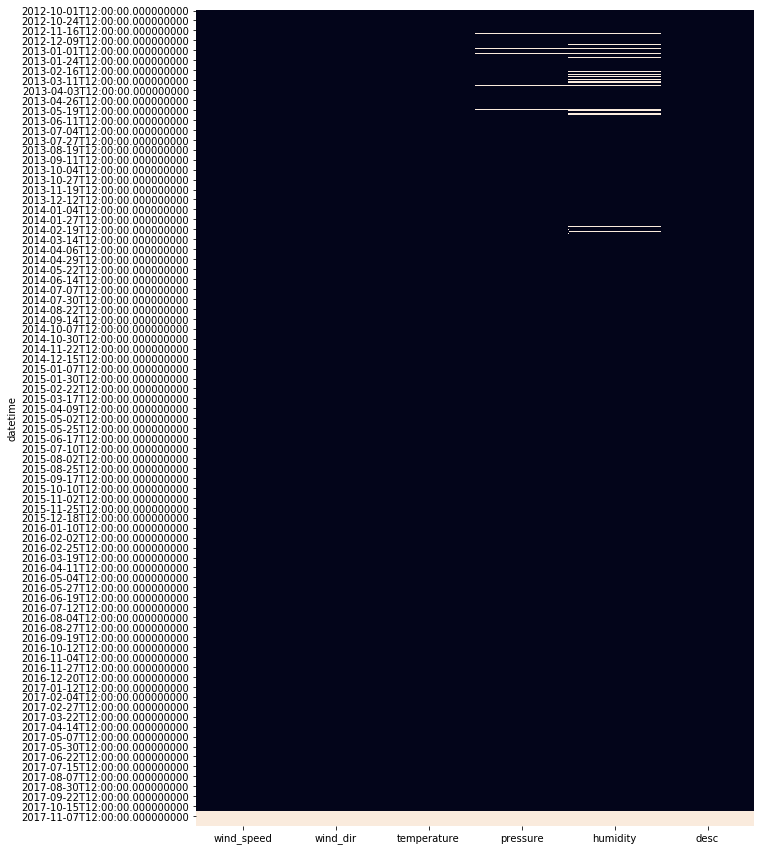

In [4]:
print(new_york.isna().sum())

fig, ax = plt.subplots(figsize=(10,15))
sns.heatmap(new_york.isnull(), cbar=False,ax=ax);

There are a number of missing values for each column and based on the heatmap, it appears that there is a cluster of them at the end of the dataframe. I wish to deal with these before further processing of the data.

First, I will fill numeric missing values by interpolation. Secondly, I will forward fill the string descriptions based on their previous values. This assumes that a missing description of the weather is best approximated as the next present value. Lastly, I will drop the rows (primarily at the end) which are missing all their attribute values.


In [5]:
#Interpolate missing values
new_york=new_york.interpolate(method='time')
#fill descriptions 
new_york['desc']=new_york['desc'].fillna(method='ffill')
#from the plot above, it appears there are time entries/rows missign all their values at the end.
#we will drop these because they lack any useful information
new_york=new_york.dropna(axis=0, how='all')
print ('missing values after replacement')
print(new_york.isna().sum())

missing values after replacement
wind_speed     0
wind_dir       0
temperature    0
pressure       0
humidity       0
desc           0
dtype: int64


I wish to double check that the time-series data is continous, especially after deleting rows with missing values. To accomplish this, I calculate a difference between a given timestamp and the next across the dataframe and see the unique values.

In [6]:
new_york['time'] = new_york.index
new_york['diff_time']= (new_york['time']-new_york['time'].shift()).fillna(0)
#print the value counts for the time differences
print (new_york['diff_time'].value_counts())
#drop these time calculations from the dataframe because they were just used for this check
new_york=new_york.drop(columns=['diff_time', 'time'])

01:00:00    45251
00:00:00        1
Name: diff_time, dtype: int64


C:\Anaconda2\envs\deeplab\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  


The data appears continously spaced by an hour (44464 instances), even after dropping rows with all missing values. The first datapoint is not spaced (00:00:00 above) because it lacks a previous point. Therefore, I know the data is continously spaced by an hour still

# Encode 'rainy' from weather descriptions

I need to define whether each timepoint (row) has rain, however this is defined by the description and many of them can be classified as rainy.

In [7]:
new_york['desc'].value_counts()

#define the unique names for each type of weather as a list
weather_cats=new_york['desc'].unique()

There are many names that can be considered rainy, they must be manually defined using my definition. After that, I will categorically classify rainy as true (1) and anything else (not rainy) as false (0) for each hour (row).

In [8]:
rain_cats=['moderate rain', 'light intensity drizzle','light rain','heavy intensity drizzle',
                         'heavy intensity rain','light rain and snow','drizzle','freezing rain','thunderstorm with rain',
                         'very heavy rain','thunderstorm with heavy rain','thunderstorm with light rain',
                         'proximity thunderstorm with rain','thunderstorm with light drizzle','proximity thunderstorm with drizzle',
                          'light intensity shower rain','shower rain']

new_york['rain']=new_york['desc']
new_york['rain']=new_york['rain'].replace(list(set(weather_cats)-set(rain_cats)),0)
new_york['rain']=new_york['rain'].replace([rain_cats],1)


print ('number of hours without rain (0) and with rain(1)')
print(new_york['rain'].value_counts())

number of hours without rain (0) and with rain(1)
0    39089
1     6163
Name: rain, dtype: int64


In [9]:
#the weather descriptions from in the past may be a useful feature in training the model, therefore we will convert these
#descriptions to categorical codes that are unique for each string
new_york['desc']=new_york['desc'].astype('category')
new_york['weather'] = new_york['desc'].cat.codes

To explore the how the various features vary over time, I plot each one.

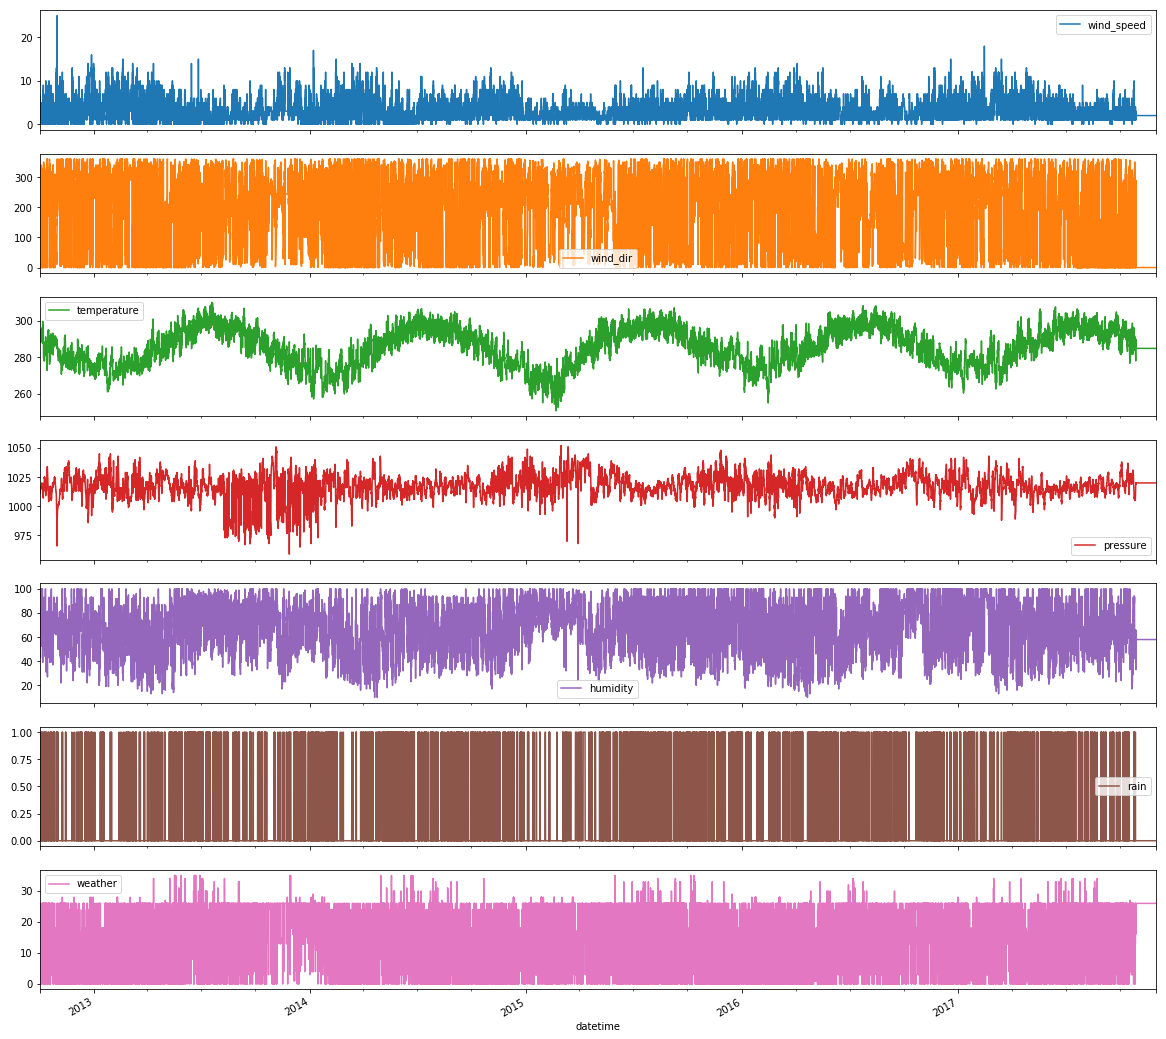

In [10]:
new_york.plot(subplots=True, figsize=(20,20));

To begin to see which features may be correlated with a rainy hour, I calculation the correlation of each feature with rain in that hour.

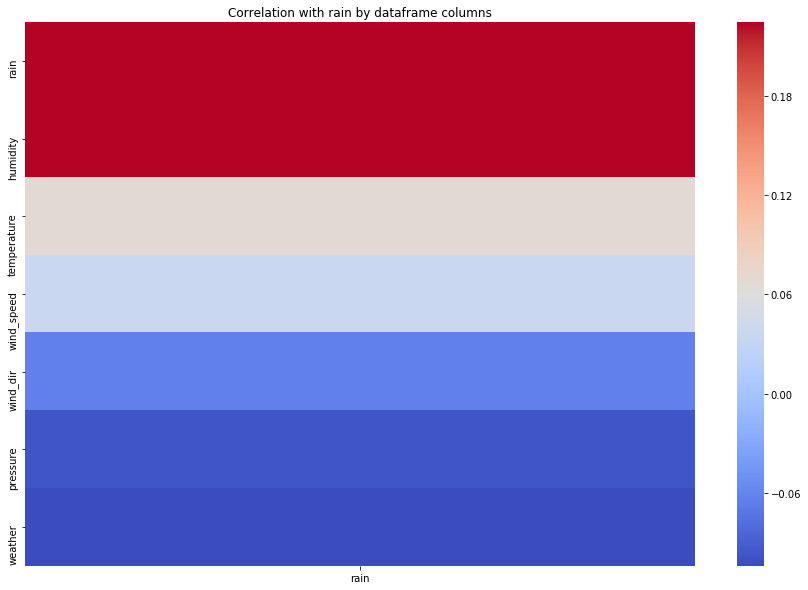

In [11]:
def corr_heatmap_by_class(df,class_to_corr,dims = (15, 10),annotate=False):
    corr=df.corr()
    fig, ax = plt.subplots(figsize=dims)

    ordered=corr[[class_to_corr]].sort_values(by=[class_to_corr],ascending=False)
    vmax=float(ordered.iloc[[1]].values)
    ax.set_title('Correlation with ' + str(class_to_corr) + ' by dataframe columns')

    return(sns.heatmap(ordered,cmap='coolwarm',vmax=vmax,annot=annotate,ax=ax))

corr_heatmap_by_class(new_york,class_to_corr='rain')

In [12]:
#define our model attributes used in predicting rain the next day
data=new_york[['wind_speed', 'wind_dir', 'temperature', 'pressure', 'humidity','weather']]

#min max scale features. Can help with neural network (below) weights not being large and unstable.
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

C:\Anaconda2\envs\deeplab\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Define what it means to be 'rainy' tomorrow

Now that we have encoded 'rain' for each hour based on the string descriptions, I must define what it means for a day to be 'rainy'. I have made these parameters modifiable, but for the purposes of this I'm defining the next day as rainy if it has at least 6 hrs of a 'rain' condition (1/4 of the day). 

To make a prediction about whether the next day (tommorow) will be rainy, I will use 24 hrs (24 preceding timepoints). Therefore, the model is asks "given 24 hrs of weather measurements, can I predict at rain of at least 6 hrs of rain the next day"

Given this, I am chunking the data into 24 hr INDEPENDENT blocks. I was initially taking hours 1-24, 2-25, 3-26, etc as individual examples but found that it introduced a high amount of autocorrelation across time, such that the model could predict rain with ~98% accuracy solely based on the previous datapoint. Data is now hours 1-24, 25-48, etc

In [13]:
X = []
y = []
#number of hours in the following day that must have rain to call the day "rainy", can be tweaked
rain_hrs=6

#how many hours prior to the next day to look back when predicting whether tomorrow will be rainy
window_size=24

for ii in range (int((len (data)-window_size)/24)):
    #first get window_size of data (preceding day or more)
    X.append(np.array(data[ii*24 :ii*24+window_size]))
    
    #next determine if at least x number of hours include rain in the next day (number of rain hours tomorrow)
    num_rain_hrs_tom=np.sum(new_york['rain'][(ii*24+24):(ii*24+window_size+24)])
    if num_rain_hrs_tom>= rain_hrs:
        y.append(1)
    elif num_rain_hrs_tom< rain_hrs:
        y.append(0)
X=np.asarray(X)
y=np.asarray(y)

In [14]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0: 1451, 1: 433}

# Define test, train, validation sets

I will first separate the new york data into two, withholding the last portion of it for the test data set (not subject to evaluation during hyperparameter tuning). In first chunk of data, I will create training and validation data using a cross validation approach. Because K-fold cross validation separates data without regard to inherent temporal patters in time series data, I will cross validate using a time series split in which the first chunk of data undergoes multiple splits while respecting temporal order.

In [15]:
print ('total number of days in dataset ' + str(np.shape(y)[0]))

total number of days in dataset 1884


Because we are asking whether it rains 'tomorrow' (a whole day), I am in effect reducing the size of the dataset to 1884 days. This makes the dataset quite small. Additional data would improve performance.

In [16]:
#create a test dataset by witholding the last 300 days
X_test=X[1584:1884,:,:]
y_test=y[1584:1884]

In [17]:
#create the training data set. The validation data will be further separated from this during cross validation.
X_train=X[0:1583,:,:]
y_train=y[0:1583]

# Create a baseline metric

For time series data, I often use the 'persistence' model for a baseline metric. In this case, it makes the prediction whether it was rainy or not based on the previous day. To calculate it, I time shift the data by 1.

In [18]:
# Create lagged dataset
values = pd.DataFrame(y_train)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't']

In [19]:
print('Accuracy on TRAINING data when using previous day as rain predictor for tomorrow ' 
      + str(accuracy_score(np.array(dataframe['t-1']).astype(int),y_train)))



Accuracy on TRAINING data when using previous day as rain predictor for tomorrow 0.7555274794693619


In [20]:
# Create lagged dataset
values = pd.DataFrame(y_test)
dataframe_test = pd.concat([values.shift(1), values], axis=1)
dataframe_test .columns = ['t-1', 't']

print('Accuracy on TEST data when using previous day as rain predictor for tomorrow ' + str(accuracy_score(np.array(dataframe_test ['t-1']).astype(int),y_test)))


test_prec,test_recall,_,_=precision_recall_fscore_support(np.array(dataframe_test ['t-1']).astype(int),y_test,average='weighted')

print('\nPrecision on TEST data when using previous day as rain predictor for tomorrow ' + str(test_prec))
print('\nPrecision on TEST data when using previous day as rain predictor for tomorrow ' + str(test_recall))


Accuracy on TEST data when using previous day as rain predictor for tomorrow 0.7233333333333334

Precision on TEST data when using previous day as rain predictor for tomorrow 0.7205882352941176

Precision on TEST data when using previous day as rain predictor for tomorrow 0.7233333333333334


C:\Anaconda2\envs\deeplab\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


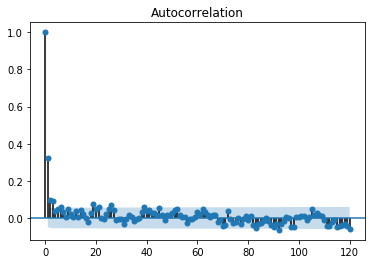

In [21]:
plot_acf(y_train, lags=120);

The accuracy is quite high just using the time-shifted prediction. In other words, whether the next day was rainy or not can be fairly well predicted based on the previous day alone. This is somewhat evident from teh autocorrelation plot of rainy days.

# Machine learning classifer for rain the next day (random forest)

In [22]:
#many of the classifiers expect 2D data, reshape the X to accomodate

nsamples, nx, ny = X_train.shape
train_X_2d =X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
test_X_2d =X_test.reshape((nsamples,nx*ny))


As mentioned above, I will use a split of the training time series data to produce the validation set for cross-validation.

In [23]:
time_split = TimeSeriesSplit(n_splits=3)

My first attempt will be to use a random-forest classifier in which the hyper parameters are tuned using grid-search and then cross-validation is performed.

In [24]:
hyper_parameters = {'n_estimators':[100,200,300], 'max_depth':[7,15,30,50],
                    'min_samples_leaf':[15,30,45], 'max_leaf_nodes':[15,45,60]}

rfc = RandomForestClassifier()
rfc_clf = GridSearchCV(rfc,hyper_parameters, scoring='accuracy',cv=2, iid = False, return_train_score=False,n_jobs=7)

cv_scores = cross_val_score(rfc_clf, train_X_2d, y_train, cv=time_split, 
                            scoring='accuracy', n_jobs=5)

In [25]:
cv_scores, cv_scores.mean()

(array([0.75443038, 0.74936709, 0.7721519 ]), 0.758649789029536)

# Deep Neural Network approach

First I will try a simple deep neural network with a single hidden layer. This model will not take into account the temporal relation of each day with regards to previous day and will evaluate each independently

For the validation data set on this, I have split the data into several chunks that maintain temporal order, but still allow for cross validation without random selection of the points. I perform three-fold cross validation (due to small dataset) on the held-out validation samples.

In [26]:
folds = list(TimeSeriesSplit(n_splits=3).split(train_X_2d, y_train))

In [27]:
#to attempt to avoid issues where the neural network learns the most common class in the imbalanced dataset, I will feed
#class weights to the network during training
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)


Fold  0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 398 samples, validate on 395 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 1s - loss: 0.5381 - acc: 0.7588 - val_loss: 0.5358 - val_acc: 0.7544
Epoch 2/100
 - 0s - loss: 0.4908 - acc: 0.7764 - val_loss: 0.6902 - val_acc: 0.7544
Epoch 3/100
 - 0s - loss: 0.4933 - acc: 0.7688 - val_loss: 0.5530 - val_acc: 0.7468
Epoch 4/100
 - 0s - loss: 0.4650 - acc: 0.7613 - val_loss: 0.5783 - val_acc: 0.7367
Epoch 5/100
 - 0s - loss: 0.4718 - acc: 0.7789 - val_loss: 0.5726 - val_acc: 0.6759
Epoch 6/100
 - 0s - loss: 0.4611 - acc: 0.7764 - val_loss: 0.5557 - val_acc: 0.7468
Epoch 7/100
 - 0s - loss: 0.4650 - acc: 0.7889 - val_loss: 0.5775 - val_acc: 0.7418
Epoch 8/100
 - 0s - loss: 0.4469 - acc: 0.8015 - val_loss: 0.5779 - val_acc: 0.7114
Epoch 9/100
 - 0s - loss: 0.4353 - acc

Epoch 87/100
 - 0s - loss: 0.1383 - acc: 0.9447 - val_loss: 1.3037 - val_acc: 0.7139
Epoch 88/100
 - 0s - loss: 0.1376 - acc: 0.9497 - val_loss: 1.2897 - val_acc: 0.6608
Epoch 89/100
 - 0s - loss: 0.1540 - acc: 0.9472 - val_loss: 1.3146 - val_acc: 0.7013
Epoch 90/100
 - 0s - loss: 0.1548 - acc: 0.9422 - val_loss: 1.3148 - val_acc: 0.7139
Epoch 91/100
 - 0s - loss: 0.1554 - acc: 0.9322 - val_loss: 1.4304 - val_acc: 0.6481
Epoch 92/100
 - 0s - loss: 0.1791 - acc: 0.9271 - val_loss: 1.5413 - val_acc: 0.7316
Epoch 93/100
 - 0s - loss: 0.1695 - acc: 0.9246 - val_loss: 1.4304 - val_acc: 0.6886
Epoch 94/100
 - 0s - loss: 0.1494 - acc: 0.9497 - val_loss: 1.3437 - val_acc: 0.6785
Epoch 95/100
 - 0s - loss: 0.1438 - acc: 0.9548 - val_loss: 1.3836 - val_acc: 0.7190
Epoch 96/100
 - 0s - loss: 0.1701 - acc: 0.9196 - val_loss: 1.4815 - val_acc: 0.7038
Epoch 97/100
 - 0s - loss: 0.1478 - acc: 0.9372 - val_loss: 1.6333 - val_acc: 0.7241
Epoch 98/100
 - 0s - loss: 0.1891 - acc: 0.9221 - val_loss: 1.430

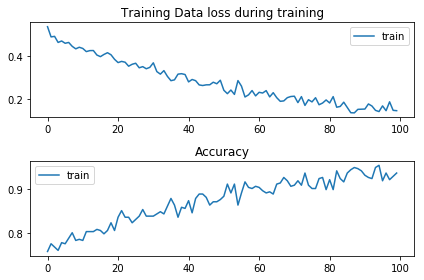

395/395 [==============================] - 0s 68us/sample - loss: 1.5382 - acc: 0.7646
[1.538202395016634, 0.76455694]

Fold  1
Train on 793 samples, validate on 395 samples
Epoch 1/100
 - 1s - loss: 0.5492 - acc: 0.7579 - val_loss: 0.5362 - val_acc: 0.7595
Epoch 2/100
 - 1s - loss: 0.5244 - acc: 0.7617 - val_loss: 0.5497 - val_acc: 0.7595
Epoch 3/100
 - 1s - loss: 0.5313 - acc: 0.7629 - val_loss: 0.5331 - val_acc: 0.7595
Epoch 4/100
 - 1s - loss: 0.5127 - acc: 0.7591 - val_loss: 0.5242 - val_acc: 0.7570
Epoch 5/100
 - 1s - loss: 0.5146 - acc: 0.7591 - val_loss: 0.5304 - val_acc: 0.7595
Epoch 6/100
 - 1s - loss: 0.5139 - acc: 0.7654 - val_loss: 0.5181 - val_acc: 0.7595
Epoch 7/100
 - 1s - loss: 0.5058 - acc: 0.7654 - val_loss: 0.5222 - val_acc: 0.7595
Epoch 8/100
 - 1s - loss: 0.5043 - acc: 0.7692 - val_loss: 0.5170 - val_acc: 0.7595
Epoch 9/100
 - 1s - loss: 0.5004 - acc: 0.7667 - val_loss: 0.5228 - val_acc: 0.7570
Epoch 10/100
 - 1s - loss: 0.4926 - acc: 0.7730 - val_loss: 0.5238 - v

Epoch 96/100
 - 1s - loss: 0.2749 - acc: 0.8865 - val_loss: 0.7821 - val_acc: 0.6785
Epoch 97/100
 - 1s - loss: 0.2208 - acc: 0.9180 - val_loss: 0.7799 - val_acc: 0.7215
Epoch 98/100
 - 1s - loss: 0.2437 - acc: 0.8991 - val_loss: 0.8410 - val_acc: 0.7038
Epoch 99/100
 - 1s - loss: 0.2450 - acc: 0.9029 - val_loss: 0.8005 - val_acc: 0.7063
Epoch 100/100
 - 1s - loss: 0.2466 - acc: 0.8928 - val_loss: 0.8730 - val_acc: 0.6835


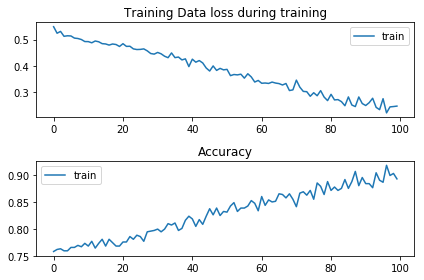

395/395 [==============================] - 0s 89us/sample - loss: 0.8730 - acc: 0.6835
[0.8729679979855501, 0.6835443]

Fold  2
Train on 1188 samples, validate on 395 samples
Epoch 1/100
 - 1s - loss: 0.5484 - acc: 0.7609 - val_loss: 0.5022 - val_acc: 0.7747
Epoch 2/100
 - 1s - loss: 0.5224 - acc: 0.7584 - val_loss: 0.4969 - val_acc: 0.7747
Epoch 3/100
 - 1s - loss: 0.5190 - acc: 0.7593 - val_loss: 0.4931 - val_acc: 0.7747
Epoch 4/100
 - 1s - loss: 0.5119 - acc: 0.7626 - val_loss: 0.4950 - val_acc: 0.7747
Epoch 5/100
 - 1s - loss: 0.5143 - acc: 0.7618 - val_loss: 0.4932 - val_acc: 0.7747
Epoch 6/100
 - 1s - loss: 0.5127 - acc: 0.7626 - val_loss: 0.4845 - val_acc: 0.7747
Epoch 7/100
 - 1s - loss: 0.5042 - acc: 0.7635 - val_loss: 0.4848 - val_acc: 0.7747
Epoch 8/100
 - 1s - loss: 0.5059 - acc: 0.7618 - val_loss: 0.4813 - val_acc: 0.7747
Epoch 9/100
 - 1s - loss: 0.4952 - acc: 0.7643 - val_loss: 0.4824 - val_acc: 0.7772
Epoch 10/100
 - 1s - loss: 0.5014 - acc: 0.7618 - val_loss: 0.4836 - 

Epoch 96/100
 - 1s - loss: 0.3235 - acc: 0.8502 - val_loss: 0.6432 - val_acc: 0.7620
Epoch 97/100
 - 1s - loss: 0.3186 - acc: 0.8552 - val_loss: 0.6301 - val_acc: 0.7671
Epoch 98/100
 - 1s - loss: 0.3318 - acc: 0.8535 - val_loss: 0.6028 - val_acc: 0.7443
Epoch 99/100
 - 1s - loss: 0.3298 - acc: 0.8451 - val_loss: 0.6017 - val_acc: 0.7696
Epoch 100/100
 - 1s - loss: 0.3224 - acc: 0.8350 - val_loss: 0.6892 - val_acc: 0.7671


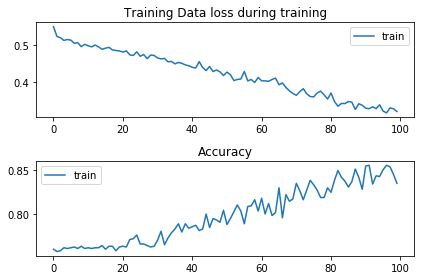

395/395 [==============================] - 0s 86us/sample - loss: 0.6892 - acc: 0.7671
[0.6892056477220753, 0.7670886]


In [28]:
#iterate through each cross validation sample, train network, plot the training loss and accuracy
accuracy_dnn=[]

for j, (train_idx, val_idx) in enumerate(folds):
    
        
    print('\nFold ',j)
    X_train_cv = train_X_2d[train_idx]
    y_train_cv = y_train[train_idx]
    X_valid_cv = train_X_2d[val_idx]
    y_valid_cv= y_train[val_idx]

    
    #define neural network model
    model = Sequential()
    model.add(Dense(100, input_dim=np.shape(X_train_cv)[1], activation='relu'))
    #dropout layer to reduce overfitting
    model.add(Dropout(0.25))
    model.add(Dense(100,  activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    history=model.fit(X_train_cv, y_train_cv, epochs=100,batch_size=5,  validation_data=(X_valid_cv, y_valid_cv),
    class_weight=class_weights,verbose=2)
    
    # plot loss during training
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.title('Training Data loss during training')
    plt.legend()
    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['acc'], label='train')
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    model_perform=model.evaluate(X_valid_cv, y_valid_cv)
    print(model_perform)
    
    accuracy_dnn.append(model_perform[1])

The accuracy on the validation dataset does not seem to be increasing at the same rate as the training set, suggesting some overfitting. Additionally, there may not be enough learning happening here after the first few epochs. Feature engineering, additional training data, or model parameter tweaking would improve this.

# Recurrent Neural Network approach (LSTM)

I may be able to improve the deep learning neural network performance with a model that takes into account the inherent time dependence of previous days and long-term temporal patterns (seasons) in predicting the weather. To do that, I will attempt to use a recurrent neural network (LSTM)

In [29]:
folds = list(TimeSeriesSplit(n_splits=3).split(X_train, y_train))

In [30]:
model_rnn = Sequential()

model_rnn.add(LSTM(50, return_sequences=True,input_shape=(window_size, 6)))
model_rnn.add(LSTM(25))
# #add dropout layer to reduce overfitting
model_rnn.add(Dropout(0.2))
#for binary crossentropy loss we have a single neuron layer with sigmoid activation
model_rnn.add(Dense(1, activation='sigmoid'))
#opt = SGD(lr= 0.000001)
opt=Adam(lr= 0.001)

model_rnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model_rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 50)            11400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 26        
Total params: 19,026
Trainable params: 19,026
Non-trainable params: 0
_________________________________________________________________
None



Fold  0
Train on 398 samples, validate on 395 samples
Epoch 1/50
 - 7s - loss: 0.6162 - acc: 0.7638 - val_loss: 0.5536 - val_acc: 0.7544
Epoch 2/50
 - 5s - loss: 0.5396 - acc: 0.7739 - val_loss: 0.5503 - val_acc: 0.7544
Epoch 3/50
 - 5s - loss: 0.5402 - acc: 0.7739 - val_loss: 0.5464 - val_acc: 0.7544
Epoch 4/50
 - 5s - loss: 0.5350 - acc: 0.7739 - val_loss: 0.5423 - val_acc: 0.7544
Epoch 5/50
 - 5s - loss: 0.5374 - acc: 0.7739 - val_loss: 0.5442 - val_acc: 0.7544
Epoch 6/50
 - 5s - loss: 0.5293 - acc: 0.7714 - val_loss: 0.5348 - val_acc: 0.7544
Epoch 7/50
 - 5s - loss: 0.5075 - acc: 0.7739 - val_loss: 0.5459 - val_acc: 0.7544
Epoch 8/50
 - 5s - loss: 0.5088 - acc: 0.7714 - val_loss: 0.5343 - val_acc: 0.7544
Epoch 9/50
 - 5s - loss: 0.4943 - acc: 0.7663 - val_loss: 0.5397 - val_acc: 0.7544
Epoch 10/50
 - 5s - loss: 0.4872 - acc: 0.7764 - val_loss: 0.5412 - val_acc: 0.7544
Epoch 11/50
 - 5s - loss: 0.4762 - acc: 0.7714 - val_loss: 0.5494 - val_acc: 0.7544
Epoch 12/50
 - 5s - loss: 0.47

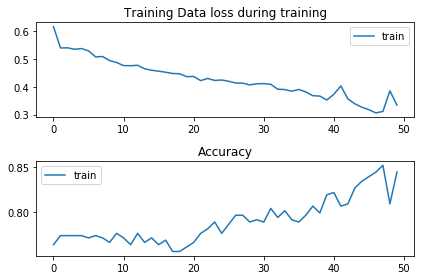

395/395 [==============================] - 0s 1ms/sample - loss: 0.8939 - acc: 0.7089
[0.893927196611332, 0.70886075]

Fold  1
Train on 793 samples, validate on 395 samples
Epoch 1/50
 - 8s - loss: 0.5317 - acc: 0.7743 - val_loss: 0.6583 - val_acc: 0.7392
Epoch 2/50
 - 8s - loss: 0.5623 - acc: 0.7453 - val_loss: 0.5441 - val_acc: 0.7570
Epoch 3/50
 - 8s - loss: 0.5397 - acc: 0.7604 - val_loss: 0.5299 - val_acc: 0.7620
Epoch 4/50
 - 8s - loss: 0.5184 - acc: 0.7629 - val_loss: 0.5365 - val_acc: 0.7595
Epoch 5/50
 - 8s - loss: 0.5119 - acc: 0.7654 - val_loss: 0.5328 - val_acc: 0.7620
Epoch 6/50
 - 8s - loss: 0.5096 - acc: 0.7667 - val_loss: 0.5340 - val_acc: 0.7544
Epoch 7/50
 - 8s - loss: 0.5045 - acc: 0.7680 - val_loss: 0.5335 - val_acc: 0.7544
Epoch 8/50
 - 8s - loss: 0.5011 - acc: 0.7680 - val_loss: 0.5345 - val_acc: 0.7544
Epoch 9/50
 - 8s - loss: 0.4968 - acc: 0.7680 - val_loss: 0.5378 - val_acc: 0.7595
Epoch 10/50
 - 8s - loss: 0.4955 - acc: 0.7718 - val_loss: 0.5360 - val_acc: 0.7

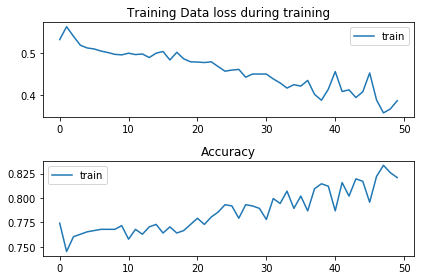

395/395 [==============================] - 0s 1ms/sample - loss: 0.6442 - acc: 0.7316
[0.6442258253882203, 0.7316456]

Fold  2
Train on 1188 samples, validate on 395 samples
Epoch 1/50
 - 12s - loss: 0.4709 - acc: 0.7862 - val_loss: 0.5579 - val_acc: 0.7696
Epoch 2/50
 - 12s - loss: 0.5170 - acc: 0.7727 - val_loss: 0.5048 - val_acc: 0.7722
Epoch 3/50
 - 12s - loss: 0.4845 - acc: 0.7820 - val_loss: 0.4997 - val_acc: 0.7772
Epoch 4/50
 - 12s - loss: 0.4714 - acc: 0.7803 - val_loss: 0.5057 - val_acc: 0.7823
Epoch 5/50
 - 12s - loss: 0.4651 - acc: 0.7912 - val_loss: 0.4978 - val_acc: 0.7722
Epoch 6/50
 - 12s - loss: 0.4729 - acc: 0.7862 - val_loss: 0.5030 - val_acc: 0.7772
Epoch 7/50
 - 13s - loss: 0.4638 - acc: 0.7879 - val_loss: 0.4901 - val_acc: 0.7747
Epoch 8/50
 - 12s - loss: 0.4438 - acc: 0.8005 - val_loss: 0.5071 - val_acc: 0.7671
Epoch 9/50
 - 12s - loss: 0.4456 - acc: 0.7938 - val_loss: 0.5062 - val_acc: 0.7696
Epoch 10/50
 - 13s - loss: 0.4386 - acc: 0.7980 - val_loss: 0.5325 - v

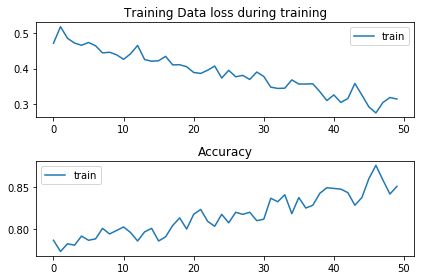

395/395 [==============================] - 1s 1ms/sample - loss: 0.6526 - acc: 0.7443
[0.6525939976112752, 0.7443038]


In [31]:
#iterate through each cross validation sample, train network, plot the training loss and accuracy
accuracy_rnn=[]

for j, (train_idx, val_idx) in enumerate(folds):
        
    print('\nFold ',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_valid_cv = X_train[val_idx]
    y_valid_cv= y_train[val_idx]

    
    hist = model_rnn.fit(
    X_train_cv,
    y_train_cv,
    epochs=50,
    batch_size=10,
    validation_data=(X_valid_cv, y_valid_cv),
    class_weight=class_weights,
    verbose=2,
    shuffle=False)
    
    
    # plot loss during training
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(hist.history['loss'], label='train')
    plt.title('Training Data loss during training')
    plt.legend()
    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(hist.history['acc'], label='train')
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    model_perform=model_rnn.evaluate(X_valid_cv, y_valid_cv)
    print(model_perform)
    
    accuracy_rnn.append(model_perform[1])

the LSTM model seemed to start to overfit the training data (increase in performance on the training data, without same increase on the cross validation data sets). A similar trend was observed with the DNN. Increasing hte dropout or stopping earlier (fewer epochs may help here).

# Comparison of models' performances on cross validated data and test data

In [32]:
scores_validation=[cv_scores,accuracy_rnn,accuracy_dnn]
names=['random forest', 'DNN', 'LSTM']

[Text(0, 0, 'random forest'), Text(0, 0, 'DNN'), Text(0, 0, 'LSTM')]

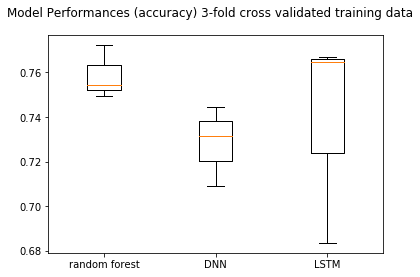

In [33]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Model Performances (accuracy) 3-fold cross validated training data')
ax = fig.add_subplot(111)
plt.boxplot(scores_validation)
ax.set_xticklabels(names)

Finally I will calculate the various performances on the test data set using accuracy, precision, and recall. 

In [34]:
rfc_fit=rfc_clf.fit(train_X_2d,y_train)
rfc_pred=rfc_clf.predict(test_X_2d)
dnn_test_pred=model.predict_classes(test_X_2d)
rnn_test_pred=model_rnn.predict_classes(X_test)

In [35]:

rfc_prec,rfc_recall,_,_=precision_recall_fscore_support(rfc_pred, y_test,average='weighted')
dnn_prec,dnn_recall,_,_=precision_recall_fscore_support(dnn_test_pred, y_test,average='weighted')
rnn_prec,rnn_recall,_,_=precision_recall_fscore_support(rnn_test_pred, y_test,average='weighted')

rfc_acc=accuracy_score(rfc_pred, y_test)
dnn_acc=accuracy_score(dnn_test_pred, y_test)
rnn_acc=accuracy_score(rnn_test_pred, y_test)


print ('Random Forest precision on test set= ' + str(rfc_prec))
print ('DNN precision on test set= ' + str(dnn_prec))
print ('LSTM precision on test set = '+ str(rnn_prec))

print ('\nRandom Forest recall on test set= ' + str(rfc_recall))
print ('DNN recall on test set= ' + str(dnn_recall))
print ('LSTM precision on test set = '+ str(rnn_recall))

print ('\nRandom Forest accuracy on test set= ' + str(rfc_acc))
print ('DNN accuracy on test set= ' + str(dnn_acc))
print ('LSTM accuracy on test set = '+ str(rnn_acc))


Random Forest precision on test set= 0.9714760097587424
DNN precision on test set= 0.8370181621035511
LSTM precision on test set = 0.7963079425318514

Random Forest recall on test set= 0.79
DNN recall on test set= 0.78
LSTM precision on test set = 0.7533333333333333

Random Forest accuracy on test set= 0.79
DNN accuracy on test set= 0.78
LSTM accuracy on test set = 0.7533333333333333


The models outperform the baseline (using the previous day to predict the next) in terms of all metrics, but the biggest improvement over the baseline is in the precision and recall scores over the baseline. The models may warrant future use or tweaking over was accomplished here, especially if a larger dataset or multiple cities can be considered in the next iteration.